In [1]:
import os

# detect gpus
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import json

### 1. Data preprocessing

In [3]:
users = pd.read_csv('../data/users.csv')
games = pd.read_csv('../data/games.csv')

games_metadata_list = []
with open('../data/games_metadata.json', 'r') as f:
    for line in f:
        games_metadata_list.append(json.loads(line))
games_metadata = pd.json_normalize(games_metadata_list)

##### games_metadata.json

In [4]:
# check for missing values
empty_description = games_metadata[games_metadata['description'] == '']
print(f"Number of empty descriptions: {len(empty_description)}")

# check for missing tags
empty_tags = games_metadata[games_metadata['tags'].apply(lambda x: len(x) == 0)]
print(f"Number of empty tags: {len(empty_tags)}")

# print some rows with empty tags
print("Rows with empty descriptions:")
print(empty_description)

print("Rows with empty tags:")
print(empty_tags)

Number of empty descriptions: 10373
Number of empty tags: 1244
Rows with empty descriptions:
        app_id description                                               tags
1        22364                                                       [Action]
7       271850              [Strategy, Simulation, Action, RTS, World War II]
18      245950              [Action, RPG, FPS, Co-op, Shooter, Action RPG,...
21      305181                                            [Adventure, Action]
30      458790                          [Adventure, Soundtrack, Visual Novel]
...        ...         ...                                                ...
50866  2362300                                                             []
50867  2296380                                                             []
50868  1272080                                                             []
50869  1402110                                                             []
50871  2488510                                   

In [5]:
# drop rows with empty tags and empty descriptions
games_metadata = games_metadata[games_metadata['description'] != '']
print(f"Number of games after dropping empty descriptions: {len(games_metadata)}")
games_metadata = games_metadata[games_metadata['tags'].apply(lambda x: len(x) > 0)]
print(f"Number of games after dropping empty tags: {len(games_metadata)}")
games_metadata = games_metadata.reset_index(drop=True)

all_tags = list(set(tag for tags in games_metadata['tags'] for tag in tags))
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)

def encode_tags(tags_list):
    return tag_encoder.transform(tags_list)

games_metadata['tags_enc'] = games_metadata['tags'].apply(encode_tags)
num_tags = len(tag_encoder.classes_)
print(f"Number of unique tags: {num_tags}")

# drop columns that are not needed
games_metadata = games_metadata.drop(columns=['tags', 'description'])

Number of games after dropping empty descriptions: 40499
Number of games after dropping empty tags: 40484
Number of unique tags: 441


In [6]:
games_metadata

,app_id,tags_enc
0,13500,"[17, 23, 271, 384, 170, 341, 283, 391, 38, 77,..."
1,113020,"[79, 363, 192, 177, 210, 367, 266, 392, 17, 24..."
2,226560,"[439, 23, 374, 17, 384, 267, 167, 185, 341, 24..."
3,249050,"[318, 367, 395, 282, 192, 301, 329, 123, 23, 2..."
4,250180,"[31, 77, 17, 79, 338, 314, 210, 335, 3, 266, 1..."
...,...,...
40479,2515240,"[185, 38, 295, 23, 426, 150, 308, 105, 7, 167,..."
40480,2455060,"[301, 192, 262, 20, 148, 17, 173, 23, 7, 320, ..."
40481,1138640,"[127, 208, 75, 191, 112, 58, 327, 221, 96, 44,..."
40482,1687000,"[338, 49, 327, 223, 208, 301, 3, 366, 245, 267..."


#### games.csv

In [7]:
# check unique values in rating column
print(games['rating'].unique())

['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive' 'Negative' 'Mostly Negative'
 'Overwhelmingly Negative' 'Very Negative']


In [8]:
# map rating to numerical values ['Very Positive' 'Positive' 'Mixed' 'Mostly Positive' 'Overwhelmingly Positive' 'Negative' 'Mostly Negative' 'Overwhelmingly Negative' 'Very Negative']
rating_map = {
    'Overwhelmingly Positive': 8,
    'Very Positive': 7,
    'Mostly Positive': 6,
    'Positive': 5,
    'Mixed': 4,
    'Mostly Negative': 3,
    'Negative': 2,
    'Very Negative': 1,
    'Overwhelmingly Negative': 0
}

games['rating'] = games['rating'].map(rating_map)
games['rating'].unique()

array([7, 5, 4, 6, 8, 2, 3, 1, 0], dtype=int64)

In [9]:
from datetime import datetime

games['app_id'] = games['app_id'].astype(int)

games['date_release'] = pd.to_datetime(games['date_release'])
current_date = datetime.now()
games['release_days'] = (current_date - games['date_release']).dt.days
games.drop('date_release', axis=1, inplace=True) 

games['win'] = games['win'].astype(int)
games['mac'] = games['mac'].astype(int)
games['linux'] = games['linux'].astype(int)

games['positive_ratio'] = games['positive_ratio'].astype(float)
games['user_reviews'] = games['user_reviews'].astype(int)

games['price_final'] = games['price_final'].astype(float)
games['price_original'] = games['price_original'].astype(float)
games['discount'] = games['discount'].astype(float)

games['steam_deck'] = games['steam_deck'].astype(int)

print(games.head())

   app_id                              title  win  mac  linux  rating  \
0   13500  Prince of Persia: Warrior Within™    1    0      0       7   
1   22364            BRINK: Agents of Change    1    0      0       5   
2  113020       Monaco: What's Yours Is Mine    1    1      1       7   
3  226560                 Escape Dead Island    1    0      0       4   
4  249050            Dungeon of the ENDLESS™    1    1      0       7   

   positive_ratio  user_reviews  price_final  price_original  discount  \
0            84.0          2199         9.99            9.99       0.0   
1            85.0            21         2.99            2.99       0.0   
2            92.0          3722        14.99           14.99       0.0   
3            61.0           873        14.99           14.99       0.0   
4            88.0          8784        11.99           11.99       0.0   

   steam_deck  release_days  
0           1          5802  
1           1          4817  
2           1          418

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd


# 1. use TF-IDF to convert the title text into numerical features
vectorizer = TfidfVectorizer(max_features=300)  # limit the number of features to 300
X_tfidf = vectorizer.fit_transform(games['title'])

# 2. use TruncatedSVD to reduce the dimensionality of the features
svd = TruncatedSVD(n_components=50)  # reduce the number of features to 50
X_reduced = svd.fit_transform(X_tfidf)

# add the reduced features to the games DataFrame
games['title_vector'] = list(X_reduced)

# print the first few rows of the DataFrame
print(games[['title', 'title_vector']].head())
games.drop('title', axis=1, inplace=True)


                               title  \
0  Prince of Persia: Warrior Within™   
1            BRINK: Agents of Change   
2       Monaco: What's Yours Is Mine   
3                 Escape Dead Island   
4            Dungeon of the ENDLESS™   

                                        title_vector  
0  [0.1686721384497246, 0.3731650054811787, -0.02...  
1  [0.4056255596883924, 0.9066350300160811, -0.06...  
2  [0.005065991352502401, -0.0029820559179664736,...  
3  [0.01183061394548646, -0.0006497957922228046, ...  
4  [0.3920505432896919, 0.1704900896053279, -0.02...  


In [11]:
games

,app_id,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector
0,13500,1,0,0,7,84.0,2199,9.99,9.99,0.0,1,5802,"[0.1686721384497246, 0.3731650054811787, -0.02..."
1,22364,1,0,0,5,85.0,21,2.99,2.99,0.0,1,4817,"[0.4056255596883924, 0.9066350300160811, -0.06..."
2,113020,1,1,1,7,92.0,3722,14.99,14.99,0.0,1,4187,"[0.005065991352502401, -0.0029820559179664736,..."
3,226560,1,0,0,4,61.0,873,14.99,14.99,0.0,1,3614,"[0.01183061394548646, -0.0006497957922228046, ..."
4,249050,1,1,0,7,88.0,8784,11.99,11.99,0.0,1,3636,"[0.3920505432896919, 0.1704900896053279, -0.02..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,1,0,0,7,96.0,101,22.00,0.00,0.0,1,378,"[0.23448365587288109, -0.10779084132202311, 0...."
50868,1272080,1,0,0,3,38.0,29458,40.00,0.00,0.0,1,385,"[0.002217280734942609, -0.00102824493043639, 0..."
50869,1402110,1,0,0,7,89.0,1128,30.00,0.00,0.0,1,395,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50870,2272250,1,0,0,7,95.0,82,17.00,0.00,0.0,1,357,"[0.0016944788354403308, -0.0002396286661628540..."


#### recommendations.csv

In [12]:
recommendations = pd.read_csv('../data/recommendations.csv')
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

recommendations['date'] = pd.to_datetime(recommendations['date'], format='%Y-%m-%d')
recommendations['year'] = recommendations['date'].dt.year
recommendations['month'] = recommendations['date'].dt.month
recommendations['day'] = recommendations['date'].dt.day
recommendations['weekday'] = recommendations['date'].dt.weekday  # Monday is 0 and Sunday is 6

recommendations.drop(columns=['date'], inplace=True)

recommendations.loc[:, 'helpful'] = recommendations['helpful'].astype(int)
recommendations.loc[:, 'funny'] = recommendations['funny'].astype(int)
recommendations.loc[:, 'hours'] = recommendations['hours'].astype(float)
# delete hours <= 2.0
recommendations = recommendations[recommendations['hours'] > 2.0]

recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})

recommendations = recommendations.drop(columns=['review_id'])

print(recommendations.head())


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_4216\959098349.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})


    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0   975370        0      0               1   36.3    51580  2022     12   12   
1   304390        4      0               0   11.5     2586  2017      2   17   
2  1085660        2      0               1  336.5   253880  2019     11   17   
3   703080        0      0               1   27.4   259432  2022      9   23   
4   526870        0      0               1    7.9    23869  2021      1   10   

   weekday  
0        0  
1        4  
2        6  
3        4  
4        6  


In [14]:
recommendations

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday
0,975370,0,0,1,36.3,51580,2022,12,12,0
1,304390,4,0,0,11.5,2586,2017,2,17,4
2,1085660,2,0,1,336.5,253880,2019,11,17,6
3,703080,0,0,1,27.4,259432,2022,9,23,4
4,526870,0,0,1,7.9,23869,2021,1,10,6
...,...,...,...,...,...,...,...,...,...,...
41154788,391220,0,0,1,18.0,9958247,2021,4,28,2
41154789,633230,0,0,1,41.0,1606890,2021,2,15,0
41154790,758870,8,0,0,8.0,1786254,2019,7,18,3
41154792,696170,0,0,1,4.0,1044289,2018,6,11,0


In [15]:
# recommendations.to_csv('../data/processed/preprocessed_recommendations.csv', index=False)

#### users.csv

In [16]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [17]:
# check how many users have 0 reviews(in recommendations.csv)
users_with_reviews = recommendations['user_id'].unique()
users_without_reviews = users[~users['user_id'].isin(users_with_reviews)]
print(f"Number of users without reviews: {len(users_without_reviews)}")

# check how many users have 0 games
# only look at products column that <= 0 in users.csv
users_with_games = users[users['products'] > 0]
users_without_games = users[~users['user_id'].isin(users_with_games['user_id'])]
print(f"Number of users without games: {len(users_without_games)}")

Number of users without reviews: 1051082
Number of users without games: 139318


In [18]:
# drop users without reviews and games
users = users[users['user_id'].isin(users_with_reviews)]
users = users[users['user_id'].isin(users_with_games['user_id'])]
users = users.reset_index(drop=True)
users

,user_id,products,reviews
0,14020781,156,1
1,8762579,329,4
2,4820647,176,4
3,5167327,98,2
4,5664667,145,5
...,...,...,...
13139325,4897585,54,2
13139326,4898597,7,1
13139327,4902361,7,1
13139328,4902380,9,1


#### merge

In [19]:
games_full = pd.merge(games, games_metadata, on='app_id', how='inner')

data = pd.merge(recommendations, games_full, on='app_id', how='inner')

data = pd.merge(data, users, on='user_id', how='inner')

In [20]:
# print first row in full text
pd.set_option('display.max_columns', None)
# make sure column content(such as list) are also fully displayed
pd.set_option('display.max_colwidth', None)
print(data.head(1))
# print type of each column
print(data.dtypes)

    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0  1544020       18      2               0    9.1  9254726  2022     12    2   

   weekday  win  mac  linux  rating  positive_ratio  user_reviews  \
0        4    1    0      0       4            62.0         21737   

   price_final  price_original  discount  steam_deck  release_days  \
0        59.99           59.99       0.0           1           679   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [21]:
# check detailed type of tags_enc and title_vector
print(type(data['tags_enc'][0]))
print(type(data['title_vector'][0]))

# # convert tags_enc and title_vector to list
# data['tags_enc'] = data['tags_enc'].apply(lambda x: list(x))
# data['title_vector'] = data['title_vector'].apply(lambda x: list(x))

# # check detailed type of tags_enc and title_vector
# print(type(data['tags_enc'][0]))
# print(type(data['title_vector'][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [22]:
# check if there are any missing values
print(data.isnull().sum())

app_id            0
helpful           0
funny             0
is_recommended    0
hours             0
user_id           0
year              0
month             0
day               0
weekday           0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
release_days      0
title_vector      0
tags_enc          0
products          0
reviews           0
dtype: int64


In [23]:
# save the processed full dataset
# data.to_csv('../data/processed/processed_full.csv', index=False)

### 2. Feature Engineering

In [24]:
# shut down full text display
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
data.head(1)

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday,...,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector,tags_enc,products,reviews
0,1544020,18,2,0,9.1,9254726,2022,12,2,4,...,21737,59.99,59.99,0.0,1,678,"[0.9077150940715599, -0.410813095011428, -0.02...","[185, 329, 375, 385, 356, 335, 21, 384, 298, 7...",724,34


In [25]:
feature_columns = ['user_id', 'app_id', 'helpful', 'funny', 'hours', 'year', 'month', 'day', 'weekday',
                   'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final',
                   'price_original', 'discount', 'steam_deck', 'release_days', 'products', 'reviews']

#### Numerical datasets

In [26]:
from sklearn.model_selection import train_test_split

# add all numerical features
title_vector_array = np.stack(data['title_vector'].values)
# find the maximum length of tags_enc
max_len = max(len(x) for x in data['tags_enc'].values)
# pad the tags_enc to the maximum length
tags_enc_array = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in data['tags_enc'].values])

# combine all features
X_numeric = data[feature_columns].values
X = np.hstack((X_numeric, title_vector_array, tags_enc_array))

# target variable
y = data['is_recommended'].values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Time series datasets

In [26]:
data.sort_values(by=['user_id', 'year', 'month', 'day'], inplace=True)

##### Only keep users with strong actions

In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# prepare the data
max_len = max(len(tags) for tags in data['tags_enc'])
fill_value = -1  # fill value for padding
sequence_length_min = 3  # minimum sequence length
sequence_length_max = 10  # maximum sequence length

# fill the tags_enc column with padding
tags_enc_padded = np.array([
    np.pad(tags, (0, max_len - len(tags)), 'constant', constant_values=fill_value)
    for tags in data['tags_enc']
])
data['tags_enc_padded'] = list(tags_enc_padded)

# extract the feature columns
feature_columns_extended = feature_columns.copy()
feature_columns_extended.append('tags_enc_padded')

X_numeric = data[feature_columns].values
tags_enc_array = np.vstack(data['tags_enc_padded'].values)
X_all = np.hstack([X_numeric, tags_enc_array])

# target variable
y_all = data['is_recommended'].values

# only keep the users with at least 3 interactions
user_interaction_counts = data['user_id'].value_counts()
valid_users = user_interaction_counts[user_interaction_counts >= sequence_length_min].index
data_filtered = data[data['user_id'].isin(valid_users)]

# rebuild the data
X_numeric = data_filtered[feature_columns].values
tags_enc_array = np.vstack(data_filtered['tags_enc_padded'].values)
X_all = np.hstack([X_numeric, tags_enc_array])
y_all = data_filtered['is_recommended'].values

In [28]:
output_dir = "../data/temp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [30]:
# define the chunk size
chunk_size = 100000

# calculate the number of sequences
num_samples = len(data_filtered)
num_sequences = num_samples - sequence_length_min + 1
num_chunks = (num_sequences + chunk_size - 1) // chunk_size  # 向上取整

chunk_counter = 0

# use tqdm to display a progress bar
for chunk_index in tqdm(range(num_chunks), desc="Processing chunks"):
    start_seq = chunk_index * chunk_size
    end_seq = min(start_seq + chunk_size, num_sequences)

    if end_seq <= start_seq:
        continue

    X_chunk = X_all[start_seq:end_seq + sequence_length_max - 1]
    y_chunk = y_all[start_seq:end_seq + sequence_length_max - 1]

    num_chunk_sequences = len(X_chunk) - sequence_length_min + 1
    if num_chunk_sequences <= 0:
        continue

    X_chunk_sequences = np.lib.stride_tricks.sliding_window_view(
        X_chunk, window_shape=(sequence_length_min, X_chunk.shape[1])
    )[:, 0, :, :]

    # if the number of sequences is less than the chunk size, pad the sequences
    padded_sequences = []
    for seq in X_chunk_sequences:
        seq_length = len(seq)
        if seq_length < sequence_length_max:
            padded_seq = np.pad(seq, ((sequence_length_max - seq_length, 0), (0, 0)), 'constant', constant_values=fill_value)
            padded_sequences.append(padded_seq)
        else:
            padded_sequences.append(seq)

    X_chunk_sequences_padded = np.array(padded_sequences)
    y_chunk_sequences = y_chunk[sequence_length_min - 1:]

    # save the chunk data
    np.save(os.path.join(output_dir, f"X_chunk_{chunk_counter}.npy"), X_chunk_sequences_padded)
    np.save(os.path.join(output_dir, f"y_chunk_{chunk_counter}.npy"), y_chunk_sequences)

    chunk_counter += 1

print(f"Data successfully saved in {output_dir}")

Processing chunks: 100%|██████████| 105/105 [02:48<00:00,  1.61s/it]

Data successfully saved in ../data/temp


In [1]:
import os
import numpy as np
import h5py

# directory containing the chunked data
output_dir = "../data/temp"
output_file = "../data/processed/sequences_strong/sequences.h5"

# create the output directory if it does not exist
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# get the list of files in the output directory
X_files = sorted([f for f in os.listdir(output_dir) if f.startswith("X_chunk")])
y_files = sorted([f for f in os.listdir(output_dir) if f.startswith("y_chunk")])

# if the output file already exists, delete it
if os.path.exists(output_file):
    os.remove(output_file)

# initialize the HDF5 file
with h5py.File(output_file, "w") as f:
    first_chunk = np.load(os.path.join(output_dir, X_files[0]))
    num_features = first_chunk.shape[2]  # feature amount
    sequence_length = first_chunk.shape[1]  # sequence length

    # create resizable datasets
    X_dset = f.create_dataset("X_sequences", shape=(0, sequence_length, num_features), maxshape=(None, sequence_length, num_features), chunks=True)
    y_dset = f.create_dataset("y_sequences", shape=(0,), maxshape=(None,), chunks=True)

    # write the first chunk to the datasets
    for chunk_counter, (X_file, y_file) in enumerate(zip(X_files, y_files)):
        # add the chunk to the HDF5 datasets
        X_chunk = np.load(os.path.join(output_dir, X_file))
        y_chunk = np.load(os.path.join(output_dir, y_file))

        # resize the datasets
        X_dset.resize(X_dset.shape[0] + X_chunk.shape[0], axis=0)
        y_dset.resize(y_dset.shape[0] + y_chunk.shape[0], axis=0)

        # write the data to the datasets
        X_dset[-X_chunk.shape[0]:] = X_chunk
        y_dset[-y_chunk.shape[0]:] = y_chunk

        # clean up the memory
        del X_chunk
        del y_chunk
        import gc
        gc.collect()

print(f"Data successfully saved in {output_file}")

Data successfully saved in ../data/processed/sequences_strong/sequences.h5


##### Full datasets with action padding

In [7]:
# set the sequance length
sequence_length = 3
fill_value = -1

In [32]:
import numpy as np
import pandas as pd
from tqdm import tqdm


# prepare the data
max_len = max(len(tags) for tags in data['tags_enc'])
tags_enc_padded = np.array([
    np.pad(tags, (0, max_len - len(tags)), 'constant', constant_values=fill_value)
    for tags in data['tags_enc']
])
data['tags_enc_padded'] = list(tags_enc_padded)

# extend the feature columns
feature_columns_extended = feature_columns.copy()
feature_columns_extended.append('tags_enc_padded')

# extract the feature columns
X_numeric = data[feature_columns].values
tags_enc_array = np.vstack(data['tags_enc_padded'].values)
X_all = np.hstack([X_numeric, tags_enc_array])

# target variable
y_all = data['is_recommended'].values


In [33]:
# define the chunk size
chunk_size = 100000

# calculate the number of sequences
num_samples = len(data)
num_sequences = num_samples - sequence_length + 1
num_chunks = (num_sequences + chunk_size - 1) // chunk_size  # 向上取整

X_sequences_list = []
y_sequences_list = []

# use tqdm to display a progress bar
for chunk_index in tqdm(range(num_chunks), desc="Processing chunks"):
    start_seq = chunk_index * chunk_size
    end_seq = min(start_seq + chunk_size, num_sequences)

    if end_seq <= start_seq:
        continue

    X_chunk = X_all[start_seq:end_seq + sequence_length - 1]
    y_chunk = y_all[start_seq:end_seq + sequence_length - 1]

    num_chunk_sequences = len(X_chunk) - sequence_length + 1
    if num_chunk_sequences <= 0:
        continue

    X_chunk_sequences = np.lib.stride_tricks.sliding_window_view(
        X_chunk, window_shape=(sequence_length, X_chunk.shape[1])
    )[:, 0, :, :]

    y_chunk_sequences = y_chunk[sequence_length - 1:]

    X_sequences_list.append(X_chunk_sequences)
    y_sequences_list.append(y_chunk_sequences)

# combine the sequences
X_sequences = np.concatenate(X_sequences_list, axis=0)
y_sequences = np.concatenate(y_sequences_list, axis=0)

# save the sequences
remaining_samples = num_samples - (num_sequences + sequence_length - 1)
if remaining_samples > 0:
    X_padding = np.full((sequence_length - remaining_samples, X_all.shape[1]), fill_value)
    X_remaining = np.vstack([X_padding, X_all[-remaining_samples:]])
    X_sequences = np.vstack([X_sequences, [X_remaining]])
    y_sequences = np.hstack([y_sequences, y_all[-1]])

Processing chunks: 100%|██████████| 170/170 [00:00<00:00, 82014.23it/s]


Temp stop

In [35]:
# save X_sequences and y_sequences
np.save('../data/processed/X_sequences.npy', X_sequences)
np.save('../data/processed/y_sequences.npy', y_sequences)

Continue

In [4]:
# read
X_sequences = np.load('../data/processed/X_sequences.npy')
y_sequences = np.load('../data/processed/y_sequences.npy')

##### Continue for strong partial sequences

In [1]:
# load the processed strong dataset 
import h5py

h5_file = '../data/processed/sequences_strong/sequences.h5'
with h5py.File(h5_file, 'r') as f:
    X_sequences = f['X_sequences'][:]
    y_sequences = f['y_sequences'][:]

print(f"X_sequences shape: {X_sequences.shape}")
print(f"y_sequences shape: {y_sequences.shape}")

X_sequences shape: (10414435, 10, 42)
y_sequences shape: (10414435,)


In [4]:
# import numpy as np

# # load original data
# X_check = np.load('../data/processed/sequences_full/X_sequences.npy')
# y_check = np.load('../data/processed/sequences_full/y_sequences.npy')

# print(f"X_check shape: {X_check.shape}")
# print(f"y_check shape: {y_check.shape}")

X_check shape: (16950341, 3, 42)
y_check shape: (16950341,)


##### Standardization for timeSeries data

In [4]:
# reshape the data
num_features = X_sequences.shape[2]
X_reshaped = X_sequences.reshape(-1, num_features)
# define float32
X_reshaped = X_reshaped.astype(np.float32)

For normal data processing

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

batch_size = 100000
fill_value = -1

num_samples = X_reshaped.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size  # 向上取整

# create a list to store the processed batch data

# initialize the list to store the processed batches
processed_batches = []

for batch_index in range(num_batches):
    start_idx = batch_index * batch_size
    end_idx = min(start_idx + batch_size, num_samples)
    
    # extract the batch data
    X_batch = X_reshaped[start_idx:end_idx]
    valid_mask = ~(X_batch == fill_value).all(axis=1)
    
    # standardize the data
    X_valid = X_batch[valid_mask]
    if X_valid.size > 0:
        scaler = StandardScaler()
        X_scaled_valid = scaler.fit_transform(X_valid)
        
        # create a new array with the same shape as X_batch
        X_batch_scaled = np.full_like(X_batch, fill_value, dtype=np.float32)
        X_batch_scaled[valid_mask] = X_scaled_valid.astype(np.float32)
    else:
        # if there are no valid samples, create an array with the same shape as X_batch
        X_batch_scaled = X_batch.astype(np.float32)
    
    # add the processed batch to the list
    processed_batches.append(X_batch_scaled)
    
    print(f"Processed batch {batch_index + 1}/{num_batches}")

# combine the processed batches
X_scaled = np.concatenate(processed_batches, axis=0)

For big sequence

In [6]:
import os
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler

# load the processed strong dataset
output_file = "../data/processed/sequences_strong/X_scaled_sequences.h5"
if os.path.exists(output_file):
    os.remove(output_file)  # 如果文件已经存在，删除它以重新创建

batch_size = 100000
fill_value = -1

# check the shape of the reshaped data
num_samples, num_features = X_reshaped.shape
num_batches = (num_samples + batch_size - 1) // batch_size  # 向上取整

# initialize the HDF5 file
with h5py.File(output_file, "w") as f:
    # create a resizable dataset
    X_scaled_dset = f.create_dataset("X_scaled", shape=(0, num_features), maxshape=(None, num_features), dtype='float32', chunks=True)

    for batch_index in range(num_batches):
        start_idx = batch_index * batch_size
        end_idx = min(start_idx + batch_size, num_samples)

        # extract the batch data
        X_batch = X_reshaped[start_idx:end_idx]
        valid_mask = ~(X_batch == fill_value).all(axis=1)

        # standardize the data
        X_valid = X_batch[valid_mask]
        if X_valid.size > 0:
            scaler = StandardScaler()
            X_scaled_valid = scaler.fit_transform(X_valid)

            # put the scaled data back into the original shape
            X_batch_scaled = np.full_like(X_batch, fill_value, dtype=np.float32)
            X_batch_scaled[valid_mask] = X_scaled_valid.astype(np.float32)
        else:
            # if there are no valid samples, create an array with the same shape as X_batch
            X_batch_scaled = X_batch.astype(np.float32)

        # write the batch to the HDF5 file
        X_scaled_dset.resize(X_scaled_dset.shape[0] + X_batch_scaled.shape[0], axis=0)
        X_scaled_dset[-X_batch_scaled.shape[0]:] = X_batch_scaled

        # clean up the memory
        del X_batch, X_batch_scaled
        import gc
        gc.collect()

        print(f"Processed and saved batch {batch_index + 1}/{num_batches}")

print(f"Data successfully saved in {output_file}")

Processed and saved batch 1/1042
Processed and saved batch 2/1042
Processed and saved batch 3/1042
Processed and saved batch 4/1042
Processed and saved batch 5/1042
Processed and saved batch 6/1042
Processed and saved batch 7/1042
Processed and saved batch 8/1042
Processed and saved batch 9/1042
Processed and saved batch 10/1042
Processed and saved batch 11/1042
Processed and saved batch 12/1042
Processed and saved batch 13/1042
Processed and saved batch 14/1042
Processed and saved batch 15/1042
Processed and saved batch 16/1042
Processed and saved batch 17/1042
Processed and saved batch 18/1042
Processed and saved batch 19/1042
Processed and saved batch 20/1042
Processed and saved batch 21/1042
Processed and saved batch 22/1042
Processed and saved batch 23/1042
Processed and saved batch 24/1042
Processed and saved batch 25/1042
Processed and saved batch 26/1042
Processed and saved batch 27/1042
Processed and saved batch 28/1042
Processed and saved batch 29/1042
Processed and saved bat

Continue

In [2]:
# load the processed strong dataset
import h5py

h5_file = '../data/processed/sequences_strong/X_scaled_sequences.h5'
with h5py.File(h5_file, 'r') as f:
    X_scaled = f['X_scaled'][:]

print(f"X_scaled shape: {X_scaled.shape}")

X_scaled shape: (104144350, 42)


In [4]:
sequence_length = X_sequences.shape[1]
num_features = X_sequences.shape[2]
print(f"Original shape: {X_sequences.shape}")
X_sequences_scaled = X_scaled.reshape(-1, sequence_length, num_features)

Original shape: (10414435, 10, 42)


In [5]:
# drop large arrays to free up memory
del X_sequences

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences_scaled, y_sequences, test_size=0.2, random_state=42
)

In [9]:
# print first row of X_train
print(X_train[0])

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.     

In [10]:
# save train and test data
np.save('../data/train/timeSeries_StrongAction/X_train.npy', X_train)
np.save('../data/test/timeSeries_StrongAction/X_test.npy', X_test)
np.save('../data/train/timeSeries_StrongAction/y_train.npy', y_train)
np.save('../data/test/timeSeries_StrongAction/y_test.npy', y_test)

### 3. Model training

In [3]:
# read train and test data

# timeSeries_StrongAction
# X_test = np.load('../data/test/timeSeries_StrongAction/X_test.npy')
# y_test = np.load('../data/test/timeSeries_StrongAction/y_test.npy')
X_train = np.load('../data/train/timeSeries_StrongAction/X_train.npy')
y_train = np.load('../data/train/timeSeries_StrongAction/y_train.npy')

# numerical
# X_train = np.load('../data/train/numerical/X_train.npy')
# X_test = np.load('../data/test/numerical/X_test.npy')
# y_train = np.load('../data/train/numerical/y_train.npy')
# y_test = np.load('../data/test/numerical/y_test.npy')

In [4]:
# check how many negative samples in train data
print(f"Number of negative samples in train data: {np.sum(y_train == 0)}")
print(f"Number of positive samples in train data: {np.sum(y_train == 1)}")

# check how many negative samples in test data
print(f"Number of negative samples in test data: {np.sum(y_test == 0)}")
print(f"Number of positive samples in test data: {np.sum(y_test == 1)}")

Number of negative samples in train data: 1580865
Number of positive samples in train data: 11979409
Number of negative samples in test data: 395685
Number of positive samples in test data: 2994384


In [4]:
# make test data balanced
# get indices of positive and negative samples
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]
num_positive_samples = len(positive_indices)
num_negative_samples = len(negative_indices)

# downsample positive samples
np.random.seed(42)
downsampled_positive_indices = np.random.choice(positive_indices, size=num_negative_samples, replace=False)
balanced_indices = np.concatenate([downsampled_positive_indices, negative_indices])

# shuffle the indices
np.random.shuffle(balanced_indices)

# get balanced test data
y_test_balanced = y_test[balanced_indices]
X_test_balanced = X_test[balanced_indices]

# check how many negative samples in balanced test data
print(f"Number of negative samples in balanced test data: {np.sum(y_test_balanced == 0)}")
print(f"Number of positive samples in balanced test data: {np.sum(y_test_balanced == 1)}")
print(f"Shape of balanced test data: {X_test_balanced.shape}")

Number of negative samples in balanced test data: 395685
Number of positive samples in balanced test data: 395685
Shape of balanced test data: (791370, 92)


##### Dataloader for big datasets

In [4]:
import numpy as np
import keras

# data loader
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X_file, y_file, batch_size=2048, shuffle=True):
        self.X_file = X_file
        self.y_file = y_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X_data = np.load(X_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.indexes = np.arange(self.X_data.shape[0])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X_batch = self.X_data[indexes]
        y_batch = self.y_data[indexes]

        return X_batch, y_batch

    @property
    def labels(self):
        return self.y_data

# DataGenerator
batch_size = 2048 
train_generator = DataGenerator('../data/train/timeSeries_StrongAction/X_train.npy',
                                '../data/train/timeSeries_StrongAction/y_train.npy',
                                batch_size=batch_size)

In [5]:
# check the first row of X_train original data
print(X_train[0])

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.     

#### Scaler for numerical datasets ONLY

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# check again after scaling
print(X_train[0])

[ 5.86144690e-01 -6.05450079e-01 -9.13440240e-02 -4.68720280e-02
  4.27310751e-01  7.30503193e-01 -2.53134537e-01  1.37850369e+00
 -1.06351936e+00  1.29023165e-02  1.23677621e+00  1.48536274e+00
  2.25564676e-01  4.87131358e-01  8.35271665e+00 -1.14038260e+00
 -1.21438255e+00 -3.19607298e-01  1.92575363e-02 -1.73346051e-01
 -3.36142412e-01 -2.07073786e-01 -4.40735413e-01 -1.46182195e-01
 -1.21424156e-01 -1.55078383e-01 -8.30348582e-03 -1.60364621e-01
 -1.32021271e-01 -1.92662417e-01 -1.91871986e-01 -2.28564512e-01
 -4.95732049e-02 -1.49748348e-02 -8.37291853e-02 -8.63709244e-02
 -2.09999108e-02 -1.12932753e-01 -7.01794547e-02 -1.21949498e-01
 -5.55791920e-02 -4.70676753e-02 -1.44020134e-01 -1.04215500e-01
  1.33354404e-01  7.78485506e-02 -1.07414871e-02 -3.60643419e-02
  1.90827085e-02 -8.73269168e-02 -1.15284837e-01  8.30226474e-03
 -1.16478862e-02 -4.96531054e-02 -1.16183149e-01  4.50318381e-02
  1.94609584e-02 -1.13900858e-01  1.83505982e-02 -1.04056432e-02
 -1.11259628e-01 -1.32998

#### Baseline NN

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

##### Baseline1 training

In [9]:
# training!
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('../model/baseline1.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=256,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2987 - accuracy: 0.8894 - val_loss: 0.2962 - val_accuracy: 0.8916
Epoch 2/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2924 - accuracy: 0.8910 - val_loss: 0.2936 - val_accuracy: 0.8919
Epoch 3/5
52970/52970 [==============================] - 139s 3ms/step - loss: 0.2907 - accuracy: 0.8914 - val_loss: 0.2897 - val_accuracy: 0.8922
Epoch 4/5
52970/52970 [==============================] - 147s 3ms/step - loss: 0.2898 - accuracy: 0.8917 - val_loss: 0.2872 - val_accuracy: 0.8929
Epoch 5/5
52970/52970 [==============================] - 140s 3ms/step - loss: 0.2892 - accuracy: 0.8919 - val_loss: 0.2899 - val_accuracy: 0.8928


#### ResNet

backbone

In [6]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping


def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # initial layer
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # first residual block
    shortcut = x
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # second residual block
    shortcut = x
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    
    # use the shortcut to adjust the dimensions
    shortcut = Dense(256)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # third residual block
    shortcut = x
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(128)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # forth residual block
    shortcut = x
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(64)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


model = create_model(X_train.shape[1])

In [7]:
import tensorflow as tf
from keras import backend as K

def focal_loss(alpha=0.13, gamma=2):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) \
               - (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        return K.mean(loss)
    return focal_loss_fixed

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(alpha=0.14, gamma=2),
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 92)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          47616       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['batch_normalization[0][0]']

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '../model/temp_resnet/resnet_baseline3_balanced_{epoch:02d}.h5', save_best_only=False, monitor='val_loss'
)

batch_size = 10192
epochs = 50

In [ ]:
# check current device
a = tf.constant(1.0)
print("Device used for computation:", a.device)

Device used for computation: /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1331/1331 [==============================] - 19s 13ms/step - loss: 0.0335 - accuracy: 0.7426 - val_loss: 0.0311 - val_accuracy: 0.7574
Epoch 2/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0311 - accuracy: 0.7622 - val_loss: 0.0302 - val_accuracy: 0.7738
Epoch 3/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0305 - accuracy: 0.7685 - val_loss: 0.0299 - val_accuracy: 0.7700
Epoch 4/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0302 - accuracy: 0.7716 - val_loss: 0.0297 - val_accuracy: 0.7755
Epoch 5/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0300 - accuracy: 0.7745 - val_loss: 0.0296 - val_accuracy: 0.7761
Epoch 6/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0299 - accuracy: 0.7755 - val_loss: 0.0294 - val_accuracy: 0.7761
Epoch 7/50
1331/1331 [==============================] - 16s 12ms/step - loss: 0.0297 - accuracy: 0.7763 - val_loss: 0.0294 -

In [ ]:
# save last model
model.save('../model/resnet_baseline3_balanced_last.h5')

##### K Fold

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=20, shuffle=True, random_state=42)

X = np.array(X_train)
y = np.array(y_train)

fold_num = 1
all_fold_histories = []

for train_index, val_index in kf.split(X):
    print(f"Training on fold {fold_num}...")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = create_model(X_train.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=focal_loss(alpha=0.14, gamma=2),
                metrics=['accuracy'])

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    all_fold_histories.append(history)
    fold_num += 1

#### ResNet Adapted

Relative shallow approach

In [ ]:
# backbone
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LeakyReLU


def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # initial layer
    x = Dense(512)(inputs)
    x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    
    # first residual block
    shortcut = x
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # second residual block
    for units in [256, 128, 64]:
        shortcut = x
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        # x = Activation('relu')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(0.3)(x)
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        
        # use the shortcut to adjust the dimensions
        shortcut = Dense(units)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
        x = Add()([x, shortcut])
        # x = Activation('relu')(x)
        x = LeakyReLU(alpha=0.1)(x)
    
    # output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

model = create_model(X_train.shape[1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 92)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          47616       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 512)          0           ['batch_normalization[0][0]']

Deep approach

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_deeper_resnet(input_dim):
    inputs = Input(shape=(input_dim,))
    
    x = Dense(1024)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    
    num_blocks = 7
    units_list = [2048, 1024, 512, 256, 128, 64, 32]
    
    for i in range(num_blocks):
        units = units_list[i % len(units_list)]
        shortcut = x
        
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(0.2)(x)
        
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Add()([x, shortcut])
        x = LeakyReLU(alpha=0.1)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


input_dim = X_train.shape[1]
model = create_deeper_resnet(input_dim)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 92)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         95232       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024)        4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 1024)         0           ['batch_normalization[0][0]']

In [ ]:
import tensorflow as tf
from keras import backend as K

def focal_loss(alpha=0.13, gamma=2):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) \
               - (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        return K.mean(loss)
    return focal_loss_fixed

In [ ]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss=focal_loss(alpha=0.13, gamma=2), metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=2048,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
6622/6622 [==============================] - 61s 9ms/step - loss: 0.0307 - accuracy: 0.7407 - val_loss: 0.0308 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 2/100
6622/6622 [==============================] - 60s 9ms/step - loss: 0.0294 - accuracy: 0.7553 - val_loss: 0.0303 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 3/100
6622/6622 [==============================] - 61s 9ms/step - loss: 0.0290 - accuracy: 0.7599 - val_loss: 0.0328 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 4/100
6622/6622 [==============================] - 59s 9ms/step - loss: 0.0288 - accuracy: 0.7624 - val_loss: 0.0288 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 5/100
6622/6622 [==============================] - 60s 9ms/step - loss: 0.0287 - accuracy: 0.7640 - val_loss: 0.0287 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 6/100
6622/6622 [==============================] - 59s 9ms/step - loss: 0.0286 - accuracy: 0.7654 - val_loss: 0.0285 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 7/100
6622/6622 [=======================

KeyboardInterrupt: 

#### Random Forest

In [7]:
import xgboost as xgb
from sklearn.utils import class_weight

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test_balanced, label=y_test_balanced)
scale_pos_weight = 0.13 / 0.87

# set the parameters
param = {
    'max_depth': 10,
    'eta': 1,
    'objective': 'binary:logistic',
    'tree_method': 'hist',        
    'device': 'cuda', 
    'num_parallel_tree': 100, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight 
}

model = xgb.train(param, dtrain, num_boost_round=1)

d:\Miniconda\envs\CV\lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [8]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_prob = model.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

print(classification_report(y_test_balanced, y_pred))
auc = roc_auc_score(y_test_balanced, y_pred_prob)
print(f'ROC-AUC Score: {auc:.4f}')

d:\Miniconda\envs\CV\lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      0.00      0.00    395685
           1       0.50      1.00      0.67    395685

    accuracy                           0.50    791370
   macro avg       0.75      0.50      0.33    791370
weighted avg       0.75      0.50      0.33    791370

ROC-AUC Score: 0.4082


#### NCF

##### For data

In [30]:
# analyze distribution of user reviews(how many reviews each user has)
user_review_counts = data['user_id'].value_counts()
print(user_review_counts.describe())

# check the position when a user has 10 reviews
position = np.sum(user_review_counts >= 5) / len(user_review_counts) * 100

print(f"user with more than 5 reviews: {position:.2f}%")

count    6.851751e+06
mean     2.473870e+00
std      6.324790e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.412000e+03
Name: count, dtype: float64
user with more than 5 reviews: 10.03%


In [31]:
# only keep users who have 5 or more reviews
valid_users = user_review_counts[user_review_counts >= 5].index
data_filtered = data[data['user_id'].isin(valid_users)]
print(f"Filtered data shape: {data_filtered.shape}")

Filtered data shape: (7799656, 25)


In [32]:
final_feature_columns = ['helpful', 'funny', 'hours', 'year', 'month', 'day', 'weekday',
                   'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final',
                   'price_original', 'discount', 'steam_deck', 'release_days', 'products', 'reviews']

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

title_vector_array = np.stack(data_filtered['title_vector'].values)
max_len = max(len(x) for x in data_filtered['tags_enc'].values)
tags_enc_array = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in data_filtered['tags_enc'].values])

X_numeric = data_filtered[final_feature_columns].values
X_combined = np.hstack((X_numeric, title_vector_array, tags_enc_array))

user_id = data_filtered['user_id'].values
app_id = data_filtered['app_id'].values

y = data_filtered['is_recommended'].values

X_train_combined, X_test_combined, y_train, y_test, X_train_user, X_test_user, X_train_item, X_test_item = train_test_split(
    X_combined, y, user_id, app_id, test_size=0.2, random_state=42
)

X_train_features = X_train_combined[:, :len(final_feature_columns)]
X_test_features = X_test_combined[:, :len(final_feature_columns)]


Encoding user and apps

In [35]:
from sklearn.preprocessing import LabelEncoder

user_ids = np.concatenate([X_train_user, X_test_user])
app_ids = np.concatenate([X_train_item, X_test_item])

# encoding user_id
user_encoder = LabelEncoder()
print("Encoding user_ids...")
user_encoder.fit(user_ids)
X_train_user_encoded = user_encoder.transform(X_train_user)
X_test_user_encoded = user_encoder.transform(X_test_user)

# encoding app_id
app_encoder = LabelEncoder()
print("Encoding app_ids...")
app_encoder.fit(app_ids)
X_train_item_encoded = app_encoder.transform(X_train_item)
X_test_item_encoded = app_encoder.transform(X_test_item)

Encoding user_ids...
Encoding app_ids...


In [37]:
# check the number of all unique users and apps before encoding
print(f"Number of unique users: {len(user_encoder.classes_)}")
print(f"Number of unique apps: {len(app_encoder.classes_)}")

# check how many in train and test data
print(f"Number of unique users in train data: {len(np.unique(X_train_user_encoded))}")
print(f"Number of unique users in test data: {len(np.unique(X_test_user_encoded))}")

# show max user_id and app_id in the train and test data
print(f"Max user_id in train data: {max(X_train_user_encoded)}")
print(f"Max user_id in test data: {max(X_test_user_encoded)}")

Number of unique users: 687286
Number of unique apps: 33642
Number of unique users in train data: 687236
Number of unique users in test data: 561375
Max user_id in train data: 687285
Max user_id in test data: 687285


Temp save

In [38]:
# save all the encoded data
np.save('../data/train/ncf/10%/X_train_user_encoded.npy', X_train_user_encoded)
np.save('../data/test/ncf/realworld_10%/X_test_user_encoded.npy', X_test_user_encoded)
np.save('../data/train/ncf/10%/X_train_item_encoded.npy', X_train_item_encoded)
np.save('../data/test/ncf/realworld_10%/X_test_item_encoded.npy', X_test_item_encoded)

In [40]:
# save test data
np.save('../data/test/ncf/realworld_10%/X_test_features.npy', X_test_features)
np.save('../data/test/ncf/realworld_10%/y_test.npy', y_test)

# save train data
np.save('../data/train/ncf/10%/X_train_features.npy', X_train_features)
np.save('../data/train/ncf/10%/y_train.npy', y_train)

In [27]:
# # balance the test data for [X_test_user, X_test_item, X_test_features], y_test
# # get indices of positive and negative samples
# positive_indices = np.where(y_test == 1)[0]
# negative_indices = np.where(y_test == 0)[0]
# num_positive_samples = len(positive_indices)
# num_negative_samples = len(negative_indices)

# # downsample positive samples
# np.random.seed(42)
# downsampled_positive_indices = np.random.choice(positive_indices, size=num_negative_samples, replace=False)
# balanced_indices = np.concatenate([downsampled_positive_indices, negative_indices])

# # shuffle the indices
# np.random.shuffle(balanced_indices)

# # get balanced test data
# y_test_balanced = y_test[balanced_indices]
# X_test_user_balanced = X_test_user[balanced_indices]
# X_test_item_balanced = X_test_item[balanced_indices]
# X_test_features_balanced = X_test_features[balanced_indices]

##### Start here

Temp continue

In [3]:
# load
X_train_user_encoded = np.load('../data/train/ncf/10%/X_train_user_encoded.npy')
X_train_item_encoded = np.load('../data/train/ncf/10%/X_train_item_encoded.npy')
X_train_features = np.load('../data/train/ncf/10%/X_train_features.npy')
y_train = np.load('../data/train/ncf/10%/y_train.npy')

In [4]:
X_test_user_encoded = np.load('../data/test/ncf/realworld_10%/X_test_user_encoded.npy')
X_test_item_encoded = np.load('../data/test/ncf/realworld_10%/X_test_item_encoded.npy')
X_test_features = np.load('../data/test/ncf/realworld_10%/X_test_features.npy')
y_test = np.load('../data/test/ncf/realworld_10%/y_test.npy')

In [5]:
import tensorflow as tf
from keras import backend as K

def focal_loss(alpha=0.13, gamma=2):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        
        loss = -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
        
        return K.mean(loss)
    return focal_loss_fixed

In [5]:
# CHECK HOW MANY POSITIVE AND NEGATIVE SAMPLES IN TRAIN DATA
print(f"Number of negative samples in train data: {np.sum(y_train == 0)}")
print(f"Number of positive samples in train data: {np.sum(y_train == 1)}")

# CHECK HOW MANY POSITIVE AND NEGATIVE SAMPLES IN TEST DATA
print(f"Number of negative samples in test data: {np.sum(y_test == 0)}")
print(f"Number of positive samples in test data: {np.sum(y_test == 1)}")

Number of negative samples in train data: 773946
Number of positive samples in train data: 5465778
Number of negative samples in test data: 193667
Number of positive samples in test data: 1366265


backbone

In [6]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2

# cheat
num_users = 687286
num_items = 33642
embedding_size = 8

def build_ncf(num_users, num_items, embedding_size):
    # user embedding
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_size, name='user_embedding')(user_input)
    user_flatten = Flatten()(user_embedding)

    # item embedding
    item_input = Input(shape=(1,), name='item_input')
    item_embedding = Embedding(input_dim=num_items+1, output_dim=embedding_size, name='item_embedding')(item_input)
    item_flatten = Flatten()(item_embedding)

    user_dense_1 = Dense(64)(user_flatten)
    leaky_relu_layer_1 = LeakyReLU(alpha=0.01)(user_dense_1)
    user_dense_2 = Dense(32)(leaky_relu_layer_1)
    leaky_relu_layer_2 = LeakyReLU(alpha=0.01)(user_dense_2)
    item_dense_1 = Dense(64)(item_flatten)
    leaky_relu_layer_3 = LeakyReLU(alpha=0.01)(item_dense_1)
    item_dense_2 = Dense(32)(leaky_relu_layer_3)
    leaky_relu_layer_4 = LeakyReLU(alpha=0.01)(item_dense_2)

    features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
    concat = Concatenate()([leaky_relu_layer_2, leaky_relu_layer_4, features_input])
    dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(concat)
    dropout_1 = Dropout(0.5)(dense_1)
    dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
    dropout_2 = Dropout(0.5)(dense_2)
    dense_3 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)
    dense_4 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense_3)
    output = Dense(1, activation='sigmoid', name='output')(dense_4)

    model = Model(inputs=[user_input, item_input, features_input], outputs=output)
    model.compile(optimizer=Adam(lr=0.001), loss=focal_loss(alpha=0.14, gamma=2), metrics=['accuracy'])
    return model

In [7]:
model = build_ncf(num_users, num_items, embedding_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         5498296     ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 8)         269144      ['item_input[0][0]']             
                                                                                              

d:\Miniconda\envs\CV\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Continue

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('../model/temp_ncf/best_ncf_model_{epoch:02d}.h5', save_best_only=False, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    [X_train_user_encoded, X_train_item_encoded, X_train_features],
    y_train,
    validation_data=([X_test_user_encoded, X_test_item_encoded, X_test_features], y_test),
    epochs=100,
    batch_size=2048,
    # class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

##### K fold

In [ ]:
# k fold
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True, random_state=42)

X = np.array(X_train_features)
y = np.array(y_train)
X_user = np.array(X_train_user_encoded)
X_item = np.array(X_train_item_encoded)

fold_num = 1
all_fold_histories = []

for train_index, val_index in kf.split(X):
    print(f"Training on fold {fold_num}...")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    X_user_fold, X_user_val_fold = X_user[train_index], X_user[val_index]
    X_item_fold, X_item_val_fold = X_item[train_index], X_item[val_index]

    model = build_ncf(num_users, num_items, embedding_size)
    model.compile(optimizer=Adam(lr=0.001), loss=focal_loss(alpha=0.14, gamma=2), metrics=['accuracy'])

    history = model.fit(
        [X_user_fold, X_item_fold, X_train_fold],
        y_train_fold,
        validation_data=([X_user_val_fold, X_item_val_fold, X_val_fold], y_val_fold),
        epochs=100,
        batch_size=2048,
        callbacks=[early_stopping, reduce_lr]
    )

    all_fold_histories.append(history)
    fold_num += 1

#### LSTM

In [6]:
import tensorflow as tf
from keras import backend as K

def focal_loss(alpha=0.13, gamma=2):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = -alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) \
               - (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        return K.mean(loss)
    return focal_loss_fixed

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking

sequence_length = 10
fill_value = -1
num_features = 42

def build_lstm_model(sequence_length, num_features, fill_value):
    model = Sequential()
    model.add(Masking(mask_value=fill_value, input_shape=(sequence_length, num_features)))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=focal_loss(alpha=0.13, gamma=2), optimizer='adam', metrics=['accuracy'])
    return model

model = build_lstm_model(sequence_length, num_features, fill_value)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 10, 42)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           306176    
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                

In [8]:
validation_generator = DataGenerator('../data/test/timeSeries_StrongAction/X_test.npy', 
                                     '../data/test/timeSeries_StrongAction/y_test.npy',
                                     batch_size=2048)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('../model/temp_lstm/lstm__strongActions_{epoch:02d}.h5', save_best_only=False, monitor='val_loss')

with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        epochs=50,
                        callbacks=[early_stopping],
                        validation_data=validation_generator,
                        # validation_freq=2,
                        # workers=8,
                        # use_multiprocessing=True,
                        )


Epoch 1/50
4068/4068 [==============================] - 149s 36ms/step - loss: 0.0317 - accuracy: 0.7205 - val_loss: 0.0308 - val_accuracy: 0.7430
Epoch 2/50
4068/4068 [==============================] - 142s 35ms/step - loss: 0.0309 - accuracy: 0.7336 - val_loss: 0.0304 - val_accuracy: 0.7557
Epoch 3/50
4068/4068 [==============================] - 143s 35ms/step - loss: 0.0305 - accuracy: 0.7377 - val_loss: 0.0301 - val_accuracy: 0.7439
Epoch 4/50
4068/4068 [==============================] - 145s 36ms/step - loss: 0.0303 - accuracy: 0.7407 - val_loss: 0.0299 - val_accuracy: 0.7394
Epoch 5/50
4068/4068 [==============================] - 143s 35ms/step - loss: 0.0301 - accuracy: 0.7429 - val_loss: 0.0298 - val_accuracy: 0.7542
Epoch 6/50
4068/4068 [==============================] - 143s 35ms/step - loss: 0.0300 - accuracy: 0.7440 - val_loss: 0.0298 - val_accuracy: 0.7398
Epoch 7/50
4068/4068 [==============================] - 143s 35ms/step - loss: 0.0299 - accuracy: 0.7455 - val_loss: 0

In [15]:
# save model
model.save('../model/balanced(best)/lstm_strongActions_alpha013.h5')

K fold

In [ ]:
# k fold
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=20, shuffle=True, random_state=42)

X = np.array(X_train)
y = np.array(y_train)

fold_num = 1
all_fold_histories = []

for train_index, val_index in kf.split(X):
    print(f"Training on fold {fold_num}...")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = build_lstm_model(sequence_length, num_features, fill_value)
    model.summary()

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=2048,
        callbacks=[early_stopping],
        verbose=1
    )

    all_fold_histories.append(history)
    fold_num += 1

#### XGBoost

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,  
    learning_rate=0.05, 
    max_depth=10,  
    subsample=0.8,
    colsample_bytree=0.8, 
    scale_pos_weight=0.1,  
    random_state=42, 
    objective='binary:logistic', 
    eval_metric='logloss', 
    tree_method = "hist", 
    device = "cuda"
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-logloss:0.79167
[1]	validation_0-logloss:0.77820
[2]	validation_0-logloss:0.76465
[3]	validation_0-logloss:0.75330
[4]	validation_0-logloss:0.74218
[5]	validation_0-logloss:0.73275
[6]	validation_0-logloss:0.72305
[7]	validation_0-logloss:0.71436
[8]	validation_0-logloss:0.70620
[9]	validation_0-logloss:0.69929
[10]	validation_0-logloss:0.69276
[11]	validation_0-logloss:0.68683
[12]	validation_0-logloss:0.68120
[13]	validation_0-logloss:0.67653
[14]	validation_0-logloss:0.67203
[15]	validation_0-logloss:0.66773
[16]	validation_0-logloss:0.66325
[17]	validation_0-logloss:0.65898
[18]	validation_0-logloss:0.65610
[19]	validation_0-logloss:0.65235
[20]	validation_0-logloss:0.64885
[21]	validation_0-logloss:0.64589
[22]	validation_0-logloss:0.64283
[23]	validation_0-logloss:0.63997
[24]	validation_0-logloss:0.63745
[25]	validation_0-logloss:0.63521
[26]	validation_0-logloss:0.63297
[27]	validation_0-logloss:0.63076
[28]	validation_0-logloss:0.62869
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Test Accuracy: 0.7216620074694645
F1 Score: 0.8186421741297291
Confusion Matrix:
[[ 316831   78854]
 [ 864731 2129653]]
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.80      0.40    395685
           1       0.96      0.71      0.82   2994384

    accuracy                           0.72   3390069
   macro avg       0.62      0.76      0.61   3390069
weighted avg       0.88      0.72      0.77   3390069



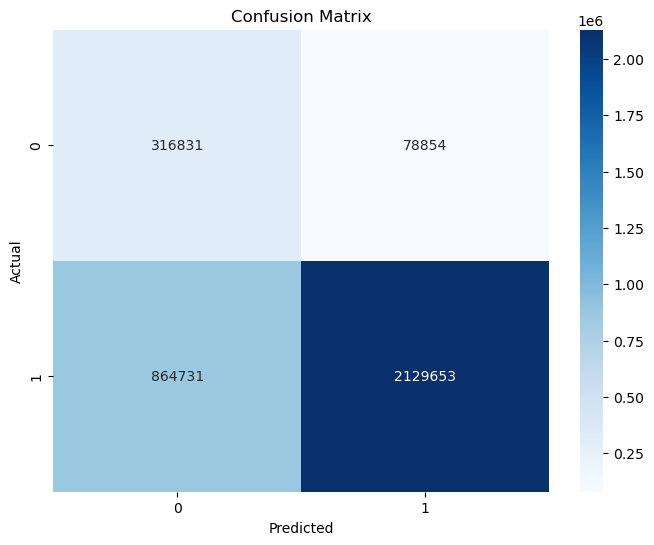

In [25]:
# draw confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 4. Model Evaluation

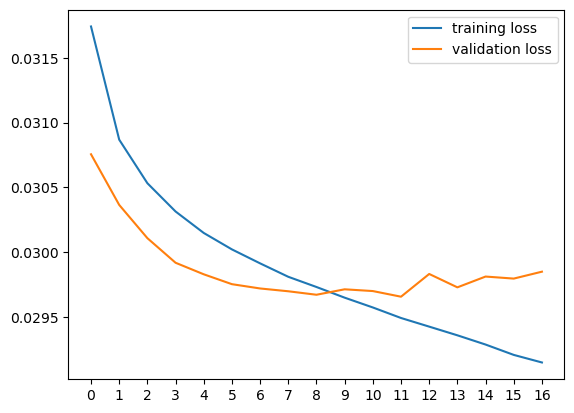

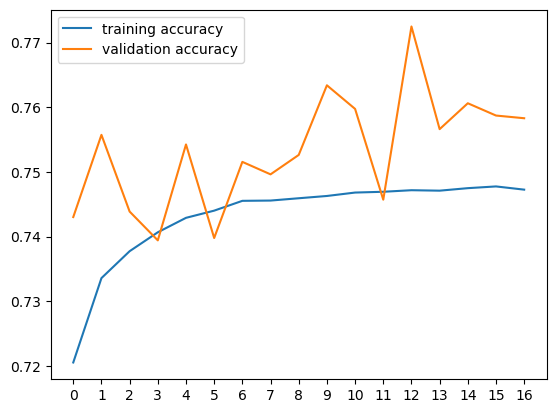

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.xticks(np.arange(0, len(history.history['loss']), step=1))

plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')

plt.xticks(np.arange(0, len(history.history['accuracy']), step=1))

plt.legend()
plt.show()


##### TimeSeries

In [50]:
# load best model
from keras.models import load_model

best_model = load_model('../model/temp_lstm/lstm__strongActions_08.h5', custom_objects={'focal_loss_fixed': focal_loss(alpha=0.14, gamma=2)})

In [51]:
loss, accuracy = best_model.evaluate(validation_generator)
print(f"val loss: {loss}")
print(f"val acc: {accuracy}")

1017/1017 [==============================] - 8s 7ms/step - loss: 0.0306 - accuracy: 0.7718
val loss: 0.03060911037027836
val acc: 0.7718411087989807


In [54]:
# load test data
X_test = np.load('../data/test/timeSeries_StrongAction/X_test.npy')
y_test = np.load('../data/test/timeSeries_StrongAction/y_test.npy')

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print(cm)

65091/65091 [==============================] - 323s 5ms/step
[[ 172371   76201]
 [ 427245 1407070]]


##### NCF

In [18]:
# load best model
from keras.models import load_model

best_model = load_model('../model/temp_ncf/best_ncf_model_53.h5', custom_objects={'focal_loss_fixed': focal_loss(alpha=0.14, gamma=2)})

In [19]:
y_pred = best_model.predict([X_test_user_encoded, X_test_item_encoded, X_test_features])
y_pred = y_pred.flatten()

48748/48748 [==============================] - 45s 930us/step


In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  52202  141465]
 [ 268511 1097754]]


##### CM

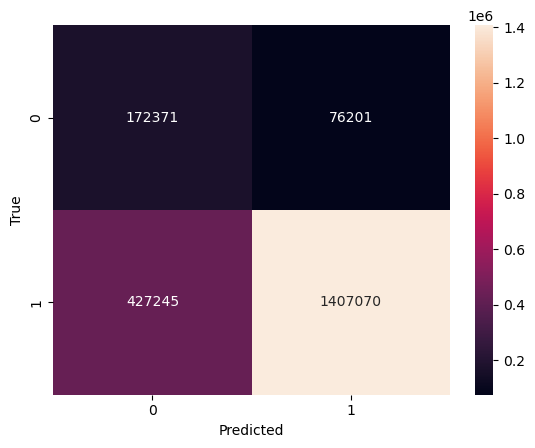

              precision    recall  f1-score   support

         0.0       0.29      0.69      0.41    248572
         1.0       0.95      0.77      0.85   1834315

    accuracy                           0.76   2082887
   macro avg       0.62      0.73      0.63   2082887
weighted avg       0.87      0.76      0.80   2082887



In [14]:
# plot cm
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))